# Evaluating Hyperparameters

### 1) Importing Libraries and Loading Data

In [12]:
import os
import time
import operator
import warnings
from math import floor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bayes_opt 

from numpy import argmax, unique, reshape

from scipy.stats import randint

from sklearn import datasets, metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import plot_tree

from bayes_opt import BayesianOptimization

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Conv1D,
    Conv2D,
    BatchNormalization,
    Flatten,
    MaxPooling1D,
    LeakyReLU
)
from tensorflow.keras.optimizers import (
    Adam,
    SGD,
    RMSprop,
    Adadelta,
    Adagrad,
    Adamax,
    Nadam,
    Ftrl
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)


In [14]:
#Create a path to where your data is stored.
path = r'C:\Users\wjzak\Dropbox\Career Foundry\Data Specialization\Module 2\01-2026- Analysis\01 Data'

In [15]:
#Read in the Regular weather data.
df = pd.read_csv(os.path.join(path, 'climate_cleaned.csv'))
df

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,BELGRADE_humidity,BELGRADE_pressure,BELGRADE_global_radiation,BELGRADE_precipitation,BELGRADE_sunshine,BELGRADE_temp_mean,BELGRADE_temp_min,BELGRADE_temp_max,BUDAPEST_cloud_cover,BUDAPEST_humidity,BUDAPEST_pressure,BUDAPEST_global_radiation,BUDAPEST_precipitation,BUDAPEST_sunshine,BUDAPEST_temp_mean,BUDAPEST_temp_min,BUDAPEST_temp_max,DEBILT_cloud_cover,DEBILT_humidity,DEBILT_pressure,DEBILT_global_radiation,DEBILT_precipitation,DEBILT_sunshine,DEBILT_temp_mean,DEBILT_temp_min,DEBILT_temp_max,DUSSELDORF_cloud_cover,DUSSELDORF_humidity,DUSSELDORF_pressure,DUSSELDORF_global_radiation,DUSSELDORF_precipitation,DUSSELDORF_sunshine,DUSSELDORF_temp_mean,DUSSELDORF_temp_min,DUSSELDORF_temp_max,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,KASSEL_humidity,KASSEL_pressure,KASSEL_global_radiation,KASSEL_precipitation,KASSEL_sunshine,KASSEL_temp_mean,KASSEL_temp_min,KASSEL_temp_max,LJUBLJANA_cloud_cover,LJUBLJANA_humidity,LJUBLJANA_pressure,LJUBLJANA_global_radiation,LJUBLJANA_precipitation,LJUBLJANA_sunshine,LJUBLJANA_temp_mean,LJUBLJANA_temp_min,LJUBLJANA_temp_max,MAASTRICHT_cloud_cover,MAASTRICHT_humidity,MAASTRICHT_pressure,MAASTRICHT_global_radiation,MAASTRICHT_precipitation,MAASTRICHT_sunshine,MAASTRICHT_temp_mean,MAASTRICHT_temp_min,MAASTRICHT_temp_max,MADRID_cloud_cover,MADRID_humidity,MADRID_pressure,MADRID_global_radiation,MADRID_precipitation,MADRID_sunshine,MADRID_temp_mean,MADRID_temp_min,MADRID_temp_max,MUNCHENB_cloud_cover,MUNCHENB_humidity,MUNCHENB_global_radiation,MUNCHENB_precipitation,MUNCHENB_sunshine,MUNCHENB_temp_mean,MUNCHENB_temp_min,MUNCHENB_temp_max,OSLO_cloud_cover,OSLO_humidity,OSLO_pressure,OSLO_global_radiation,OSLO_precipitation,OSLO_sunshine,OSLO_temp_mean,OSLO_temp_min,OSLO_temp_max,SONNBLICK_cloud_cover,SONNBLICK_humidity,SONNBLICK_pressure,SONNBLICK_global_radiation,SONNBLICK_precipitation,SONNBLICK_sunshine,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,STOCKHOLM_cloud_cover,STOCKHOLM_pressure,STOCKHOLM_global_radiation,STOCKHOLM_precipitation,STOCKHOLM_sunshine,STOCKHOLM_temp_mean,STOCKHOLM_temp_min,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max,KASSEL_cloud_cover,STOCKHOLM_humidity,MUNCHENB_pressure
0,19600101,1,7,0.85,1.0180,0.32,0.09,0.7,6.5,0.8,10.9,1,0.81,1.0195,0.88,0.00,7.0,3.7,-0.9,7.9,4,0.67,1.017,0.44,0.01,2.3,2.4,-0.4,5.1,7,0.85,1.0032,0.07,0.25,0.0,9.3,7.4,11.0,8,0.83,1.0161,0.12,0.08,0.0,10.0,7.0,11.5,7,0.91,1.0010,0.13,0.22,0.0,10.6,9.4,8.3,0.82,1.0094,0.28,0.48,1.6,7.9,3.9,9.4,8,1.00,1.0173,0.20,0.00,0.0,-0.6,-1.9,0.5,7,0.83,1.0063,0.22,0.32,1.0,9.5,8.5,11.1,6,0.92,1.0260,0.53,0.00,1.4,7.6,4.4,10.8,5,0.67,0.20,0.10,0.0,6.9,1.1,10.4,8,0.98,0.9978,0.04,1.14,0.0,4.9,3.8,5.9,4,0.73,1.0304,0.48,0.01,2.3,-5.9,-8.5,-3.2,5,1.0114,0.05,0.32,0.0,4.2,2.2,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9,8,0.98,1.0304
1,19600102,1,6,0.84,1.0180,0.36,1.05,1.1,6.1,3.3,10.1,6,0.84,1.0172,0.25,0.00,0.0,2.9,2.2,4.4,4,0.67,1.017,0.18,0.31,0.0,2.3,1.4,3.1,8,0.90,1.0056,0.14,0.06,0.1,7.7,6.4,8.3,8,0.89,1.0161,0.18,0.66,0.5,8.2,7.4,11.0,7,0.98,1.0051,0.13,0.23,0.0,6.1,3.9,10.6,0.86,1.0086,0.12,0.27,0.0,7.7,6.8,9.1,6,0.94,1.0173,0.56,0.13,3.2,2.1,-1.3,5.5,8,0.92,1.0062,0.17,1.34,0.4,8.6,7.5,9.9,7,0.86,1.0254,0.46,0.00,0.9,9.8,7.4,12.2,6,0.72,0.61,0.30,5.1,6.2,4.2,10.2,8,0.62,1.0139,0.04,0.00,0.0,3.4,2.8,4.9,6,0.97,1.0292,0.21,0.61,0.0,-9.5,-10.5,-8.5,5,1.0114,0.05,0.06,0.0,4.0,3.0,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1,6,0.62,1.0292
2,19600103,1,8,0.90,1.0180,0.18,0.30,0.0,8.5,5.1,9.9,6,0.77,1.0179,0.67,0.00,3.5,3.1,-0.5,6.4,4,0.67,1.017

In [16]:
#Read in the Pleasant weather data.
pleasant = pd.read_csv(os.path.join(path, 'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'))
pleasant

,DATE,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,19600101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,19600102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19600103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,19600104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19600105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22945,20221027,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22946,20221028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22947,20221029,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22948,20221030,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2) Data Cleaning for Exercise

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22950 entries, 0 to 22949
Columns: 137 entries, DATE to MUNCHENB_pressure
dtypes: float64(120), int64(17)
memory usage: 24.0 MB


In [18]:
pleasant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22950 entries, 0 to 22949
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   DATE                         22950 non-null  int64
 1   BASEL_pleasant_weather       22950 non-null  int64
 2   BELGRADE_pleasant_weather    22950 non-null  int64
 3   BUDAPEST_pleasant_weather    22950 non-null  int64
 4   DEBILT_pleasant_weather      22950 non-null  int64
 5   DUSSELDORF_pleasant_weather  22950 non-null  int64
 6   HEATHROW_pleasant_weather    22950 non-null  int64
 7   KASSEL_pleasant_weather      22950 non-null  int64
 8   LJUBLJANA_pleasant_weather   22950 non-null  int64
 9   MAASTRICHT_pleasant_weather  22950 non-null  int64
 10  MADRID_pleasant_weather      22950 non-null  int64
 11  MUNCHENB_pleasant_weather    22950 non-null  int64
 12  OSLO_pleasant_weather        22950 non-null  int64
 13  SONNBLICK_pleasant_weather   22950 non-null  i

In [19]:
df.shape

(22950, 137)

In [20]:
pleasant.shape

(22950, 16)

In [21]:
# Filter data for years 2000-2009
# Convert DATE column to string and extract year
df['Year'] = df['DATE'].astype(str).str[:4].astype(int)
pleasant['Year'] = pleasant['DATE'].astype(str).str[:4].astype(int)

# Filter for years 2000-2009
df_2000 = df[(df['Year'] >= 2000) & (df['Year'] <= 2009)].reset_index(drop=True)
pleasant_2000 = pleasant[(pleasant['Year'] >= 2000) & (pleasant['Year'] <= 2009)].reset_index(drop=True)

# Drop the Year column if you don't need it
df_2000 = df_2000.drop(columns=['Year'])
pleasant_2000 = pleasant_2000.drop(columns=['Year'])

print(f"Climate data 2000-2009 shape: {df_2000.shape}")
print(f"Pleasant weather data 2000-2009 shape: {pleasant_2000.shape}")

# Display first few rows
print("\nClimate Data (2000-2009) - First 5 rows:")
print(df_2000.head())

print("\nPleasant Weather Data (2000-2009) - First 5 rows:")
print(pleasant_2000.head())

Climate data 2000-2009 shape: (3653, 137)
Pleasant weather data 2000-2009 shape: (3653, 16)

Climate Data (2000-2009) - First 5 rows:
       DATE  MONTH  BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
0  20000101      1                  8            0.89          1.0286   
1  20000102      1                  8            0.87          1.0318   
2  20000103      1                  5            0.81          1.0314   
3  20000104      1                  7            0.79          1.0262   
4  20000105      1                  5            0.90          1.0246   

   BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
0                    0.20                 0.03             0.0   
1                    0.25                 0.00             0.0   
2                    0.50                 0.00             3.7   
3                    0.63                 0.35             6.9   
4                    0.51                 0.07             3.7   

   BASEL_temp_mean  BASEL_temp

In [22]:
# prepping for Random Forest
x = df_2000.drop(columns=['DATE','MONTH'])
x.shape

(3653, 135)

In [23]:
y = pleasant_2000['BASEL_pleasant_weather']  # Example target variable
y.shape

(3653,)

In [24]:
# Conversion step:
x = np.array(x)  # X contains the weather features (like temperature, humidity, etc.)
y = np.array(y)  # y contains whether the day was 'pleasant' (1) or not (0)

# Check:
print("Feature matrix shape (x):", x.shape)  # Should print (3652, 135)
print("Target variable shape (y):", y.shape)  # Should print (3652,)

Feature matrix shape (x): (3653, 135)
Target variable shape (y): (3653,)


### 3) Random Forest Model- Optimization

#### Grid and Random Search

In [25]:
stations = {
0: 'BASEL',
1: 'BELGRADE',
2: 'BUDAPEST',
3: 'DEBILT',
4: 'DUSSELDORF',
5: 'HEATHROW',
6: 'KASSEL',
7: 'LJUBLJANA',
8: 'MAASTRICHT',
9: 'MADRID',
10: 'MUNCHENB',
11: 'OSLO',
12: 'SONNBLICK',
13: 'STOCKHOLM',
14: 'VALENTIA'
}

In [26]:
# Create train and test splits from the reshaped arrays
from sklearn.model_selection import train_test_split

# Split the reshaped data (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2, 
    random_state=42
)

print("Train and Test Set Shapes:")
print("=" * 60)
print(f"X_train shape: {x_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Train and Test Set Shapes:
X_train shape: (2922, 135)
X_test shape: (731, 135)
y_train shape: (2922,)
y_test shape: (731,)


#### Grid Search

In [27]:
# creating a RF classifier
clf = RandomForestClassifier()

In [28]:
# Grid search cv
grid_space={'max_depth':[3,10,None],
              'n_estimators':[100,200],
              'max_features':[1,5,10,15],
              'min_samples_leaf':[1,2],
              'min_samples_split':[1,2,3]
           }

In [ ]:
start = time.time()
grid = GridSearchCV(clf,param_grid=grid_space,cv=3,scoring='accuracy', verbose=3, n_jobs=-2)
model_grid = grid.fit(x_train, y_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Search took 0.25090951919555665 minutes


In [31]:
# Print grid search results

print('Best GRID search hyperparameters are: '+str(model_grid.best_params_))
print('Best GRID search score is: '+str(model_grid.best_score_))

Best GRID search hyperparameters are: {'max_depth': None, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Best GRID search score is: 0.9893908281998631


In [ ]:
#Improving Optimization Further using best results:
# Grid search cv
grid_space={'max_depth':[None],
              'n_estimators':[100, 150, 200],
              'max_features':[15,20,30],
              'min_samples_leaf':[1,2,3,4],
              'min_samples_split':[1,2,3]
           }

In [33]:
start = time.time()
grid = GridSearchCV(clf,param_grid=grid_space,cv=3,scoring='accuracy', verbose=3, n_jobs=-2)
model_grid = grid.fit(x_train, y_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Search took 0.29496446847915647 minutes


In [34]:
# Print grid search results

print('Best GRID search hyperparameters are: '+str(model_grid.best_params_))
print('Best GRID search score is: '+str(model_grid.best_score_))

Best GRID search hyperparameters are: {'max_depth': None, 'max_features': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best GRID search score is: 0.9972621492128679


#### Random Search

In [35]:
# Define random search cv

rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(15, 135),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

In [36]:
# creating a RF classifier
clf2= RandomForestClassifier()

In [38]:
start = time.time()
rf_random = RandomizedSearchCV(clf2, rs_space, n_iter=200, scoring='accuracy', verbose=3, n_jobs=-2, cv=3)
model_random = rf_random.fit(x_train, y_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Search took 2.091797649860382 minutes


In [39]:
# random random search results
print('Best RANDOM search hyperparameters are: '+str(model_random.best_params_))
print('Best RANDOM search score is: '+str(model_random.best_score_))

Best RANDOM search hyperparameters are: {'criterion': 'entropy', 'max_depth': None, 'max_features': 69, 'min_samples_leaf': 2, 'min_samples_split': np.int64(8), 'n_estimators': np.int64(260)}
Best RANDOM search score is: 0.9996577686516085


In [40]:
# grid search results
print('Best GRID search hyperparameters are: '+str(model_grid.best_params_))
print('Best GRID search score is: '+str(model_grid.best_score_))
# random random search results
print('Best RANDOM search hyperparameters are: '+str(model_random.best_params_))
print('Best RANDOM search score is: '+str(model_random.best_score_))

Best GRID search hyperparameters are: {'max_depth': None, 'max_features': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best GRID search score is: 0.9972621492128679
Best RANDOM search hyperparameters are: {'criterion': 'entropy', 'max_depth': None, 'max_features': 69, 'min_samples_leaf': 2, 'min_samples_split': np.int64(8), 'n_estimators': np.int64(260)}
Best RANDOM search score is: 0.9996577686516085


The Grid Search gave a similar accuracy score for far less time, we will use the Grid Search parameters to conserve resources. There is likely a way to improve the optimization further but at cost. 

##### Using Optimized Parameters

In [41]:
# creating a RF classifier
clf3 = RandomForestClassifier(max_depth=None, max_features=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100) 
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf3.fit(x_train, y_train)

RandomForestClassifier(max_features=30, min_samples_leaf=2)

In [42]:
# performing predictions on the test dataset
y_pred = clf3.predict(x_test)
  
# using metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Model Accuracy:  1.0


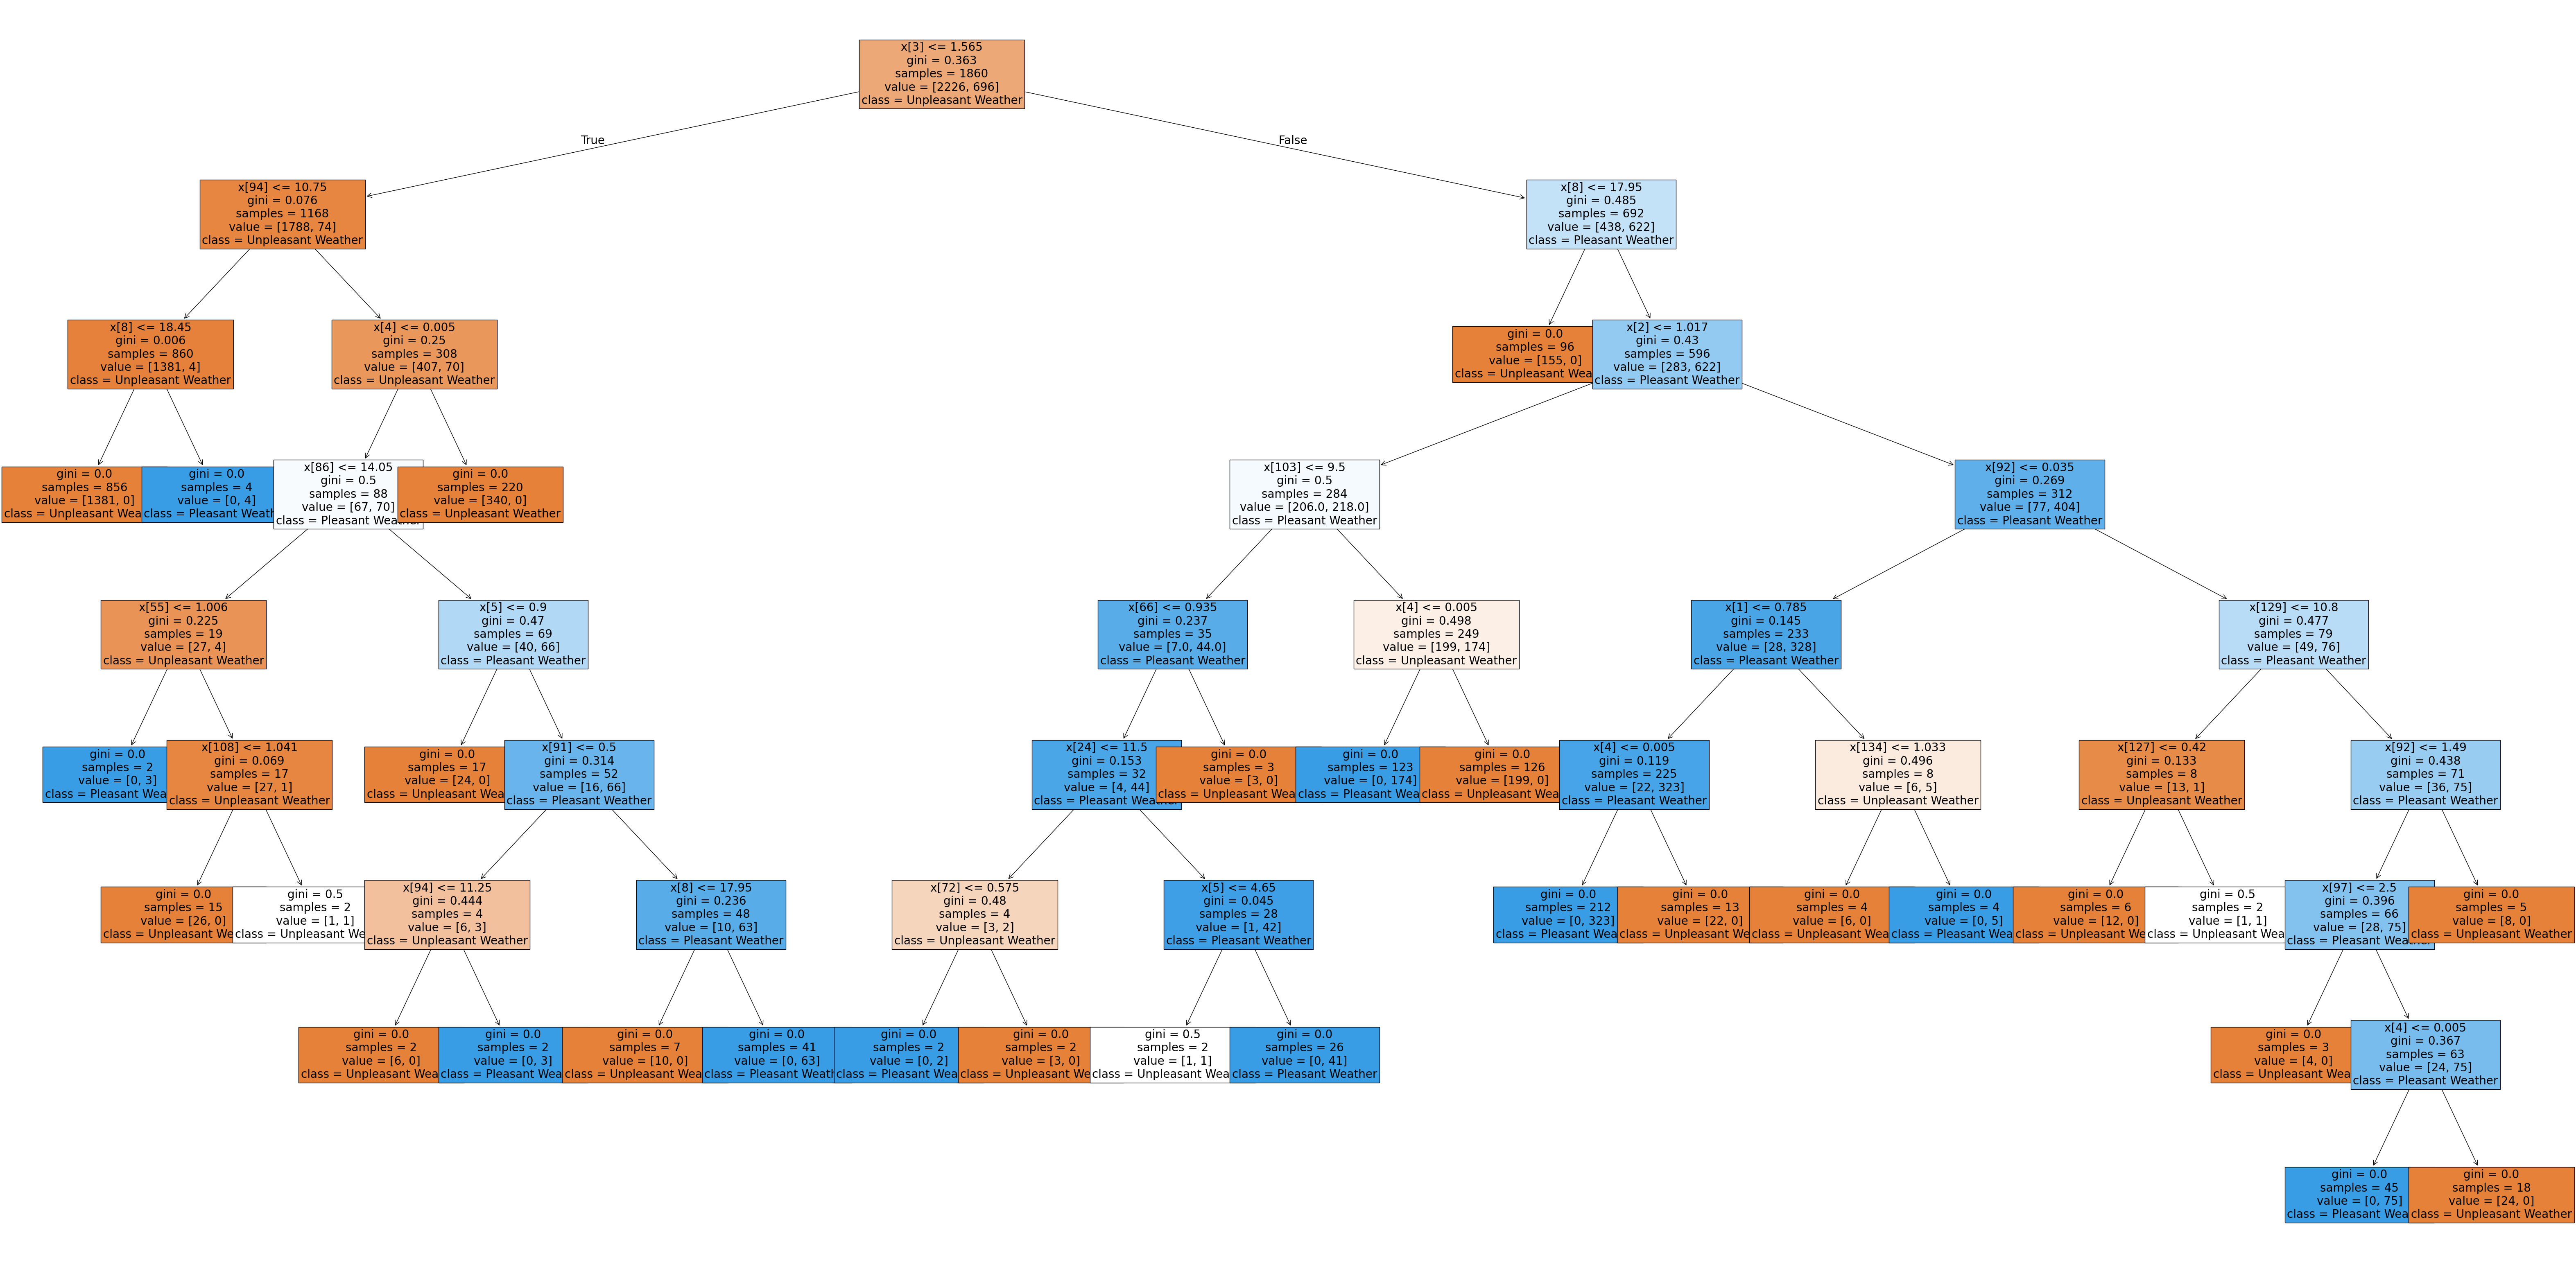

In [44]:
#Pleasant Weather indicator for class_names label at leaves
p_weather = ['Unpleasant Weather', 'Pleasant Weather']

# Plot the tree
fig = plt.figure(figsize=(80, 40))
plot_tree(clf3.estimators_[15], 
          filled=True, 
          fontsize=20,
          feature_names=None,
          class_names=p_weather);  # Adds class labels at the leaves

#### Important Features

feature_importances_ shape: (135,)
[1.53918107e-02 8.46119930e-03 5.39366581e-03 1.02346414e-01
 2.86799421e-01 9.65994477e-02 4.81856666e-02 1.53877281e-03
 1.37135070e-01 5.40820946e-04 8.29305652e-04 2.22503811e-03
 1.56711390e-03 2.98942487e-04 1.43275701e-03 1.85099091e-03
 6.05068900e-04 1.15272429e-03 1.92927192e-04 2.49236573e-04
 1.62622373e-03 1.30329039e-03 3.72428838e-04 1.14764965e-03
 3.32362830e-03 4.60500440e-04 1.42081668e-03 2.86869755e-04
 4.81168602e-04 3.23963410e-03 7.56199542e-04 5.84024617e-04
 8.81637142e-04 2.82722018e-03 5.48266766e-04 7.96778033e-03
 7.59319133e-04 6.49245768e-04 4.34313606e-03 5.10670113e-04
 1.79047301e-03 8.32602903e-04 8.10163539e-03 6.38783887e-04
 2.02992565e-02 3.84283388e-04 6.09808640e-04 7.08634947e-04
 1.06490909e-03 2.52493774e-04 1.00780583e-03 1.21545942e-03
 3.84670865e-04 3.90494451e-03 6.61747974e-04 7.90454888e-03
 5.50440417e-04 1.05482555e-03 8.78149529e-04 6.82696330e-03
 7.58589160e-04 2.14648781e-03 2.16763257e-04 1.07

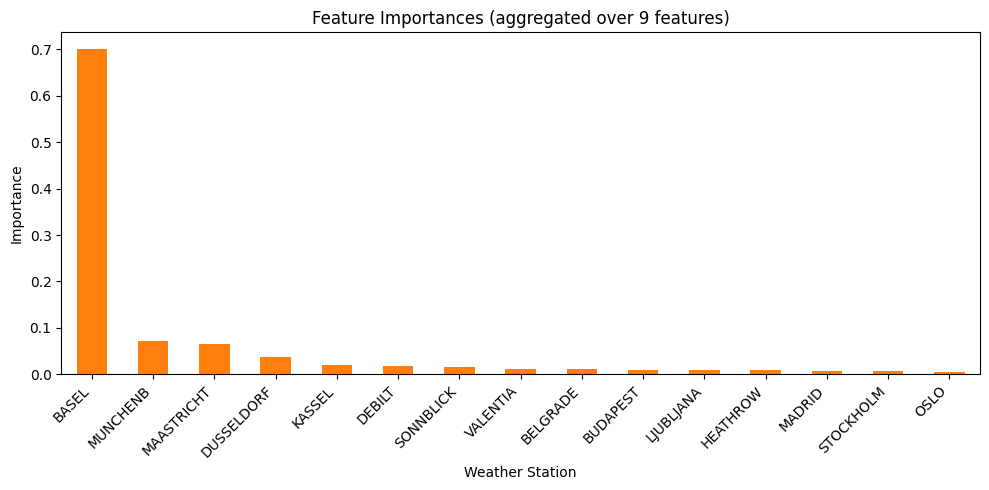

In [51]:
# 1) Raw importances (correspond to columns of x in order)
importances = clf3.feature_importances_
print("feature_importances_ shape:", importances.shape)
print(importances)

# 2) Map importances back to feature names (optional)
feature_names = list(df_2000.drop(columns=['DATE','MONTH']).columns)
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(feat_imp_df.head(10))

# 3) Aggregate per station (assumes column order is station1_feat1..station15_feat9)
imp_matrix = importances.reshape(15, 9)   # (15 stations, 9 measurements)
station_imp = imp_matrix.sum(axis=1)

# 4) Create labeled Series and sort
station_names = [stations[i] for i in sorted(stations.keys())]
station_importances = pd.Series(station_imp, index=station_names).sort_values(ascending=False)
print("\nStation importances (sorted):\n", station_importances)

# 5) Plot
plt.figure(figsize=(10,5))
station_importances.plot.bar(color='C1')
plt.ylabel('Importance')
plt.xlabel('Weather Station')
plt.title('Feature Importances (aggregated over 9 features)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#### Important Station Optimization (Basel)

In [52]:
# Keep only BASEL variables and drop DATE / MONTH
df_basel = df[
    [col for col in df.columns if 'BASEL' in col and col not in ['DATE', 'MONTH']]
].reset_index(drop=True)

pleasant_basel = pleasant[
    [col for col in pleasant.columns if 'BASEL' in col and col not in ['DATE', 'MONTH']]
].reset_index(drop=True)

print(f"Climate BASEL data shape: {df_basel.shape}")
print(f"Pleasant BASEL data shape: {pleasant_basel.shape}")

print("\nClimate Data (BASEL) - First 5 rows:")
print(df_basel.head())

print("\nPleasant Weather Data (BASEL) - First 5 rows:")
print(pleasant_basel.head())

Climate BASEL data shape: (22950, 9)
Pleasant BASEL data shape: (22950, 1)

Climate Data (BASEL) - First 5 rows:
   BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  BASEL_global_radiation  \
0                  7            0.85           1.018                    0.32   
1                  6            0.84           1.018                    0.36   
2                  8            0.90           1.018                    0.18   
3                  3            0.92           1.018                    0.58   
4                  6            0.95           1.018                    0.65   

   BASEL_precipitation  BASEL_sunshine  BASEL_temp_mean  BASEL_temp_min  \
0                 0.09             0.7              6.5             0.8   
1                 1.05             1.1              6.1             3.3   
2                 0.30             0.0              8.5             5.1   
3                 0.00             4.1              6.3             3.8   
4                 0.14         

In [53]:
# Conversion step for BASEL
x = np.array(df_basel)                     # feature matrix for BASEL
y = np.array(pleasant_basel['BASEL_pleasant_weather'])  # target

# Check shapes
print("BASEL feature matrix shape:", x.shape)
print("BASEL target variable shape:", y.shape)

BASEL feature matrix shape: (22950, 9)
BASEL target variable shape: (22950,)


In [54]:
# Split the reshaped data (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2, 
    random_state=42
)

print("Train and Test Set Shapes:")
print("=" * 60)
print(f"X_train shape: {x_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Train and Test Set Shapes:
X_train shape: (18360, 9)
X_test shape: (4590, 9)
y_train shape: (18360,)
y_test shape: (4590,)


##### Grid Search

In [55]:
# creating a RF classifier
clf = RandomForestClassifier()

In [56]:
# Grid search cv
grid_space={'max_depth':[5,10,None],
              'n_estimators':[100,200],
              'max_features':[5,10,15, 20],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }

In [57]:
start = time.time()
grid = GridSearchCV(clf,param_grid=grid_space,cv=3,scoring='accuracy', verbose=3, n_jobs=-2)
model_grid = grid.fit(x_train, y_train)
print('Search took %s minutes' % ((time.time() - start)/60))

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Search took 0.4690231680870056 minutes


In [58]:
# grid search results
print('Best GRID search hyperparameters are: '+str(model_grid.best_params_))
print('Best GRID search score is: '+str(model_grid.best_score_))

Best GRID search hyperparameters are: {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best GRID search score is: 1.0


In [59]:
# creating a RF classifier
clf2 = RandomForestClassifier(max_depth=5, max_features=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf2.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, max_features=5)

In [60]:
# performing predictions on the test dataset
y_pred = clf2.predict(x_test)
  
# using metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Model Accuracy:  1.0


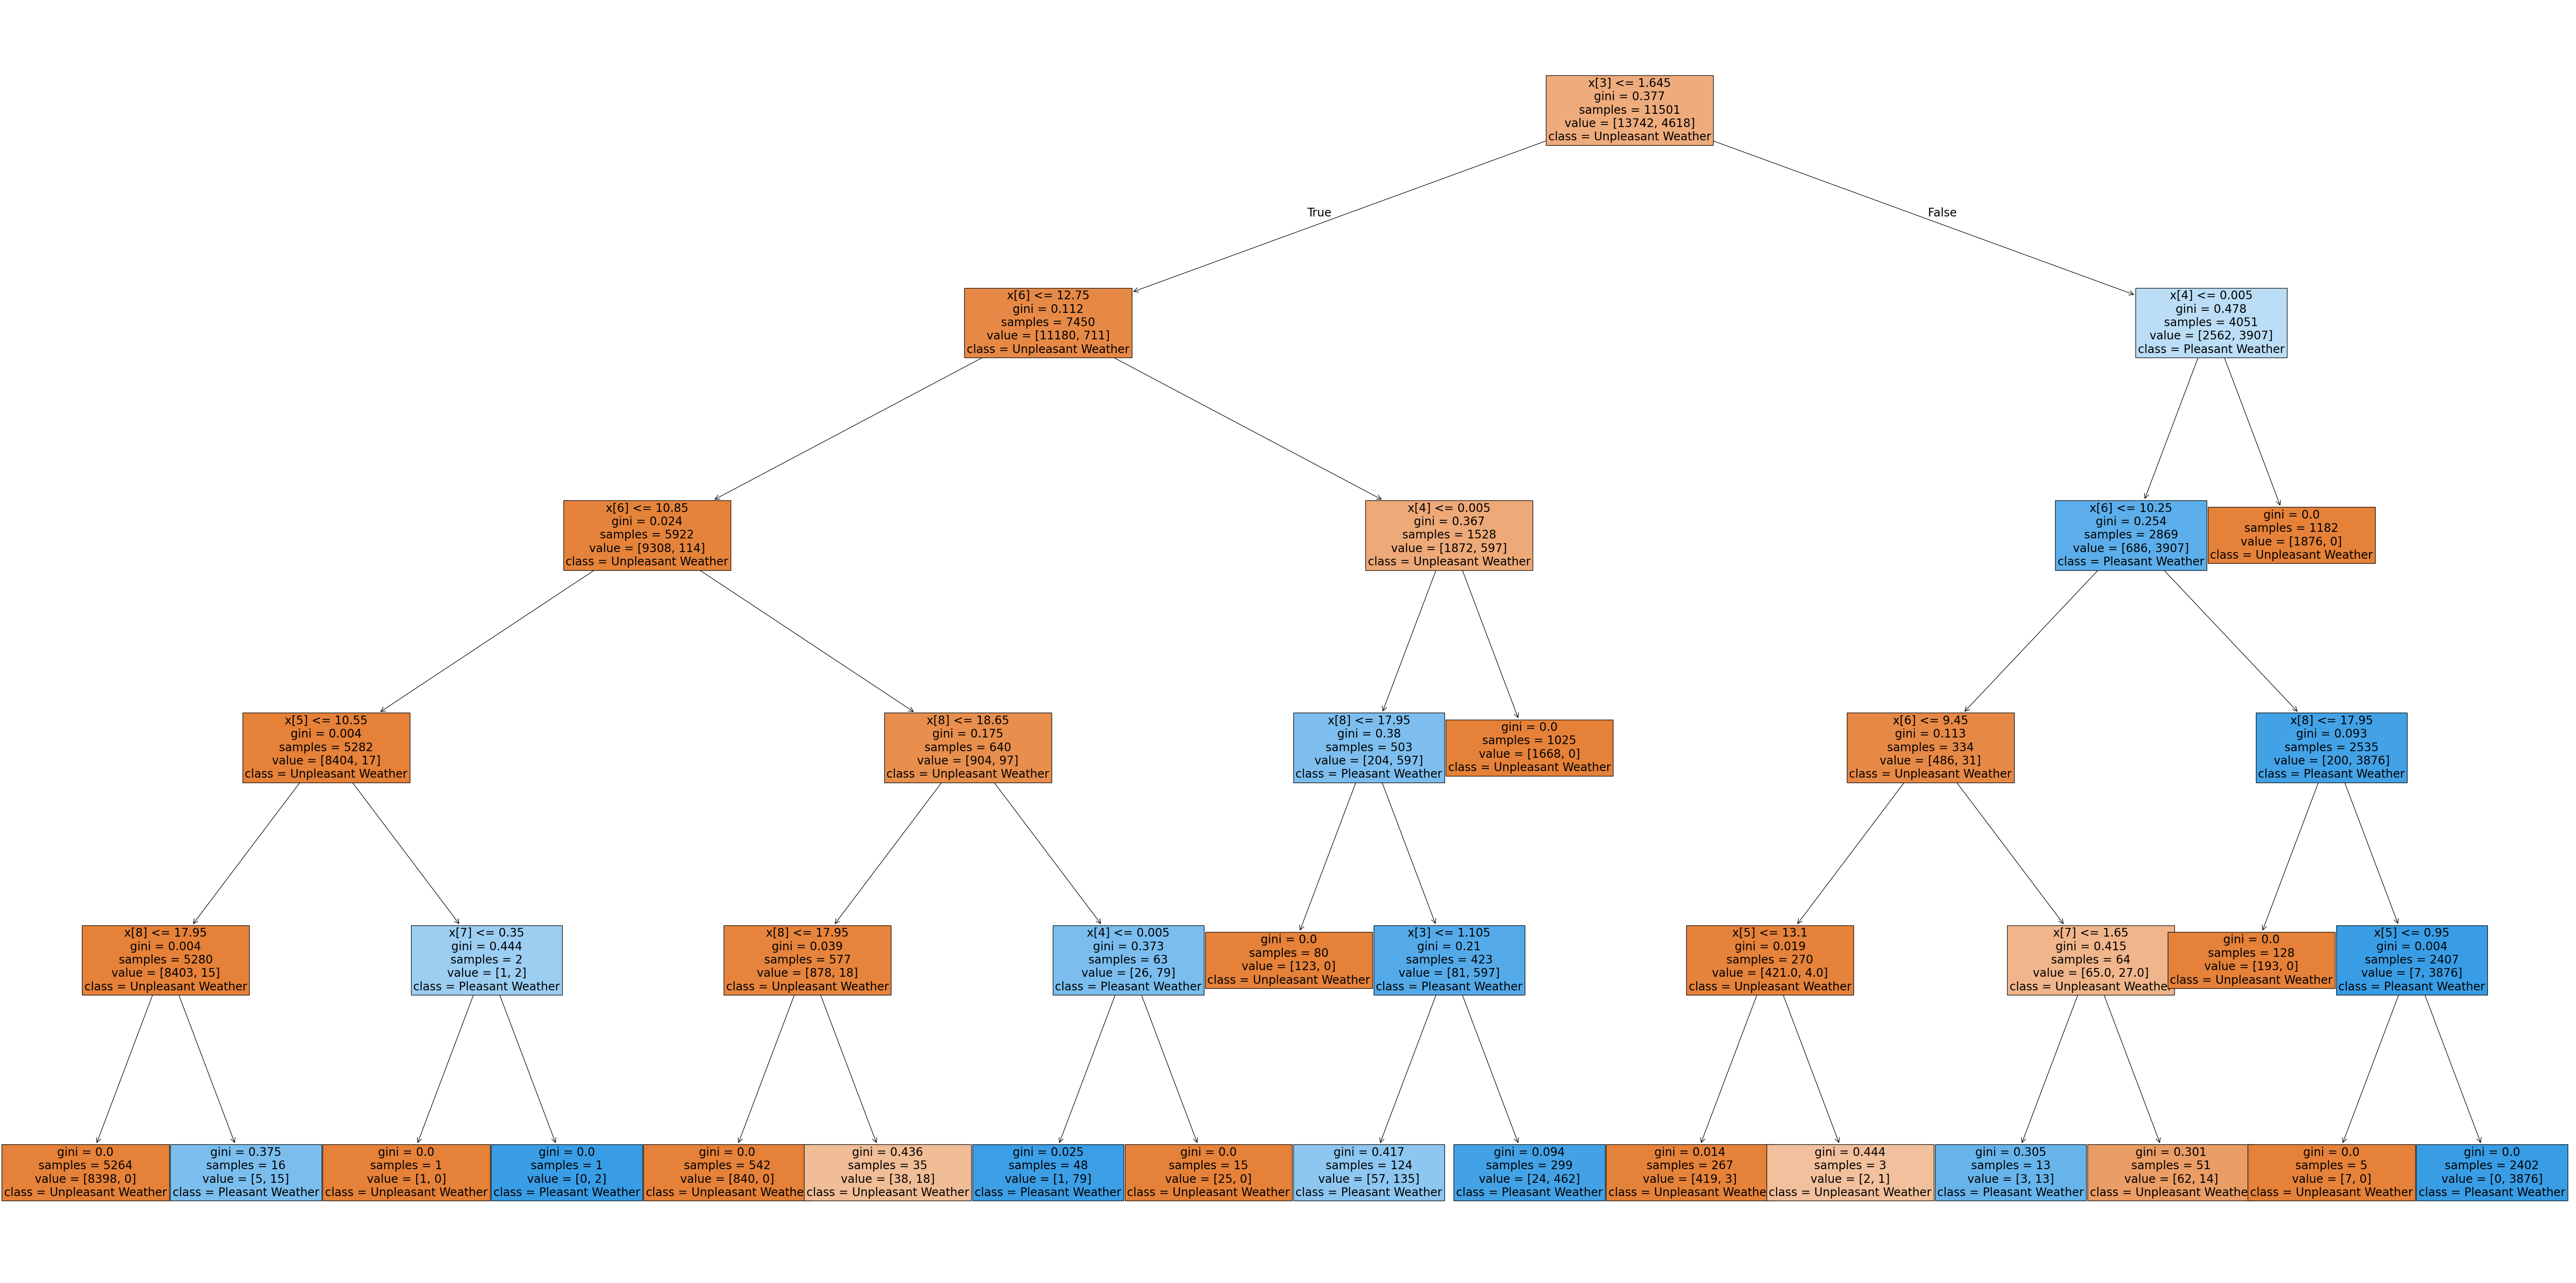

In [61]:
#Pleasant Weather indicator for class_names label at leaves
p_weather = ['Unpleasant Weather', 'Pleasant Weather']

# Plot the tree
fig = plt.figure(figsize=(80, 40))
plot_tree(clf2.estimators_[15], 
          filled=True, 
          fontsize=20,
          feature_names=None,
          class_names=p_weather);  # Adds class labels at the leaves

In [62]:
np.set_printoptions(threshold=np.inf)
newarray = clf2.feature_importances_
#print(clf.feature_importances_.shape)
newarray

array([0.00791245, 0.00099596, 0.00234302, 0.113526  , 0.3988977 ,
       0.10026125, 0.04845613, 0.00342249, 0.324185  ])

In [63]:
#Clean feature names from BASEL columns

features = [feature.replace('BASEL_', '') for feature in df_basel]
features

['cloud_cover',
 'humidity',
 'pressure',
 'global_radiation',
 'precipitation',
 'sunshine',
 'temp_mean',
 'temp_min',
 'temp_max']

In [64]:
# Create Series for feature importance

important = pd.Series(newarray, index=features).sort_values(ascending=False)
important

precipitation       0.398898
temp_max            0.324185
global_radiation    0.113526
sunshine            0.100261
temp_mean           0.048456
cloud_cover         0.007912
temp_min            0.003422
pressure            0.002343
humidity            0.000996
dtype: float64

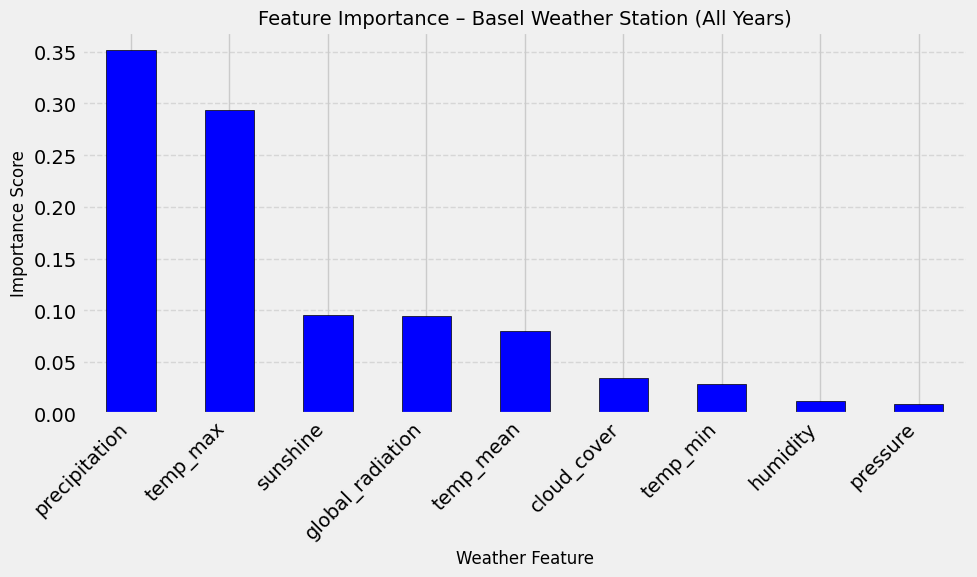

In [145]:
# Plot feature importance

plt.figure(figsize=(10, 6))
important.plot(kind='bar', color='blue', edgecolor='black')

plt.title('Feature Importance – Basel Weather Station (All Years)', fontsize=14)
plt.xlabel('Weather Feature', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()